Generative language models trained to predict what comes next have been shown to be a very useful foundation for models that can perform a wide variety of traditionally difficult language tasks.
*Perplexity* is the standard measure of how well such a model can predict the next word on a given text, and it's very closely related to *cross-entropy* and *bits-per-byte*.
It's a measure of how effective the language model is on the text, and in certain settings aligns with [how well the model performs downstream tasks](https://arxiv.org/pdf/2403.08540) (although [not in all settings](https://openreview.net/pdf?id=f2OYVDyfIB)) and can be used for [selecting data for training models](https://arxiv.org/abs/2409.05816).
These metrics can be applied to any next token prediction model independent of its model architecture which makes it a broadly applicable tool.
Note however that it can't be directly to masked language models like BERT or T5, although there [related pseudo-log likelihoods](https://arxiv.org/abs/2305.10588)).

This article goes through in detail what perplexity is, how it relates to cross-entropy loss and compression, and how to compute it for the GPT 2 transformer model in PyTorch.
If you just want an overview of what the various measures of language modelling are then read Chip Huyen's [what perplexity and related metrics mean](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/).
If you just want to compute some perplexities I recommend the [huggingface documentation on perplexity](https://huggingface.co/docs/transformers/perplexity) (though note that their perplexity score is wrong for WikiText-2 because they average over GPT-2 tokens rather than words!) or [lm_perplexity](https://github.com/asahi417/lmppl).
If you want to understand why the calculation works, with examples in Python, and understand how to compare results in the literature then read on.

# Language modelling

## GPT 2

The 2019 Open AI paper [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) showed that scaling up language modelling on a diverse corpora could produce a model that could then be used for a variety of tasks without further fine-tuning including summarisation, translation, and question answering.
This paper introduced prompt design by using `TL;DR:` to get a summary, and [in-context learning](https://ai.stanford.edu/blog/understanding-incontext/) (in this paper they refer to this as "zero-shot" because there is no training, but now it would be phrased as few-shot in-context learning, a term introduced in the [GPT 3 paper](https://arxiv.org/pdf/2005.14165)).

Let's load in the largest language model Open AI have released the weights for to date, the 1.5 billion parameter GPT2 XL:

In [1]:
# Imports

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F

from collections import Counter
import math
from pathlib import Path
import re
from urllib.request import urlretrieve
from zipfile import ZipFile

import matplotlib.pyplot as plt

torch.manual_seed(1727672233025);

In [2]:
model_name = 'gpt2-xl'

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          clean_up_tokenization_spaces=False)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto")

print(f'Model {model.config.name_or_path} has ' +
      f'{model.num_parameters()/ 1e6:0.1f} million parameters')

Model gpt2-xl has 1557.6 million parameters


If we start with some input text (one of the examples from the original GPT 2 paper and [blog post](https://openai.com/index/better-language-models)):

In [3]:
text = "In a shocking finding, scientist discovered a herd of unicorns " \
       "living in a remote, previously unexplored valley, in the Andes " \
       "Mountains. Even more surprising to the researchers was the fact " \
       "that the unicorns spoke perfect English.\n"

print(text)

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.



We can convert it into numerical tokens for the model based on its vocabulary:

In [4]:
tokens = tokenizer(text, return_tensors='pt')['input_ids']

And then iteratively predict the next token to complete the story:

In [5]:
generation = model.generate(
    tokens.to(model.device),
    attention_mask=torch.ones_like(tokens).to(model.device),
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=1,
    max_new_tokens = 512)

print(tokenizer.decode(generation[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The scientists were researching the possibility that unicorns exist when they found a herd of the rare creatures, which they named the "Prairie Unicorn", in a narrow valley in the Aguas Calientes National Park in Peru, Peru.

The group of five had been trekking through the mountain range, about 1,700m above sea level, when the locals informed them that the animals were near the valley's edge.

Dr Rodrigo Estevez, of the University of Granada in Spain and a co-author of the new study, told El Mundo: "In most mountain areas of the Andes Mountains, there are many species of animals, including birds and animals. However, we had never known that there were unicorns.

"Since the group had not encountered [unicorns] previously and they were very curious, they start

Note this is different to the example generation from the blog post because this process is random.
I actually had to try a few different random seeds to get a result this good (although with more sophisticated search we could get better results with the same model).

## Predicting the next token

Language modelling works by predicting the probability distribution for the next token out of all possible tokens.
For example take our input text above:

In [6]:
text

'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n'

We converted that into numeric tokens:

In [7]:
tokens

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   198]])

Each token corresponds to part of a word via a learned Byte Pair Encoding:

In [8]:
'_'.join([tokenizer.decode(t) for t in tokens[0]])

'In_ a_ shocking_ finding_,_ scientist_ discovered_ a_ herd_ of_ unic_orns_ living_ in_ a_ remote_,_ previously_ unexpl_ored_ valley_,_ in_ the_ And_es_ Mountains_._ Even_ more_ surprising_ to_ the_ researchers_ was_ the_ fact_ that_ the_ unic_orns_ spoke_ perfect_ English_._\n'

For each token input the model outputs 50257 values, that is one for each element of the vocabulary:

In [9]:
with torch.inference_mode():
    logits = model(tokens.to(model.device)).logits.cpu()
print(f'{tokens.shape=}, {logits.shape=}, {tokenizer.vocab_size=}')

tokens.shape=torch.Size([1, 46]), logits.shape=torch.Size([1, 46, 50257]), tokenizer.vocab_size=50257


These are *multinomial logits*, which we denote $z_i$, to get probabilities we need to pass them through the softmax function:

$$ p(z)_i = \frac{\exp(z_i)}{\sum_{t \in V} \exp(z_t)}$$

Where the sum is over all tokens $t$ in the vocabulary $V$.
The probabilities can be very small and the sum of exponentials can result in underflow or overflow.
However the probability is invariant under a shift of logits, so we translate them so the logits maximum value is zero to make it more numerically stable.

$$ p(z)_i = \frac{\exp(z_i - \max(z))}{\sum_{t \in V} \exp(z_t - \max(z))}$$

In [10]:
# z - max(z)
norm_logits = logits - logits.max(dim=-1, keepdim=True).values

# exp(z - max(z))
probs = norm_logits.exp()
# exp(z - max(z)) / sum(exp(z) - max(z))
probs /= probs.sum(axis=-1, keepdim=True)

probs

tensor([[[6.2914e-05, 1.9333e-04, 3.6167e-06,  ..., 1.2496e-07,
          3.1714e-08, 2.4391e-05],
         [3.3396e-06, 9.7791e-06, 2.0923e-07,  ..., 2.0211e-08,
          2.7631e-08, 8.2515e-06],
         [1.9861e-05, 4.0516e-05, 4.5341e-07,  ..., 3.0855e-08,
          1.5996e-09, 3.6109e-06],
         ...,
         [2.6970e-02, 1.4128e-04, 2.4664e-07,  ..., 2.3159e-09,
          4.5612e-09, 2.3378e-04],
         [5.7984e-06, 9.9157e-05, 9.3441e-07,  ..., 5.5791e-09,
          1.3838e-08, 7.3431e-03],
         [1.9724e-07, 1.1957e-04, 2.6362e-06,  ..., 4.0896e-10,
          2.8109e-10, 8.8093e-06]]])

This is similar to what you get from calling Pytorch's `softmax` function:

In [11]:
assert torch.allclose(F.softmax(logits, dim=-1), probs, atol=5e-5)

probs = F.softmax(logits, dim=-1)

For example let's consider the token corresponding to perfect:

In [12]:
tokenizer.decode(tokens[0,-4])

' perfect'

We can look at the probabilities of the next token:

In [13]:
next_token_prob = probs[0,-4]
next_token_prob

tensor([4.7597e-06, 6.2952e-06, 1.5840e-07,  ..., 3.3299e-09, 6.6634e-10,
        2.7599e-06])

Which sum to 1:

In [14]:
next_token_prob.sum()

tensor(1.0000)

We can see the most likely next tokens, which are all reasonable guesses for the language the unicorns spoke:

In [15]:
for _idx in next_token_prob.argsort(descending=True)[:5]:
    print(f'{next_token_prob[_idx]:0.2%}\t', tokenizer.decode(_idx))

64.57%	  English
17.82%	  Spanish
2.26%	  Latin
2.02%	 ,
1.81%	  human


By picking a random token weighted by its probability we can sample text:

In [16]:
next_token = torch.multinomial(probs[0,-1], 1)

next_token, tokenizer.decode(next_token)

(tensor([198]), '\n')

And by iterating this process we can generate text.

# Evaluating language models

How do we say how *good* a language model is at predicting the next word in a corpus of text?
We can use *accuracy* (acc), how well the most likely prediction matches the actual truth, but this is a very difficult goal for general datasets and is insensitive to small changes in the model.
It is better to measure how likely the text is given the model, and *perplexity* (ppl) is a standard measure of this (normalised by the length of the text).
It's also possible to view the likelihood through an information theory lens of compressibility, and the related measures of bits per byte (bpb) and bits per character (bpc).
All of these measures were used in the GPT 2 paper:


 Model  | LAMBADA (PPL) | LAMBADA (ACC) | CBT-CN (ACC) | CBT-NE (ACC) | WikiText2 (PPL) | PTB (PPL) | enwik8 (BPB) | text8 (BPC) | WikiText103 (PPL) | 1BW (PPL) |
|--------|---------------|---------------|--------------|--------------|----------------|-----------|--------------|-------------|------------------|-----------|
| 117M   | 35.13         | 45.99         | 87.65        | 83.4         | 29.41          | 65.85     | 1.16         | 1.17        | 37.50            | 75.20     |
| 345M   | 15.60         | 55.48         | 92.35        | 87.1         | 22.76          | 47.33     | 1.06         | 1.06        | 26.37            | 55.72     |
| 762M   | 10.87         | 60.12         | 93.45        | 88.0         | 19.93          | 40.31     | 0.97         | 1.02        | 22.05            | 44.575    |
| 1542M  | 8.63          | 63.24         | 93.30        | 89.05        | 18.34          | 35.76     | 0.93         | 0.98        | 17.48            | 42.16     |


This section will go through these different measures and how they're connected.

## Likelihood of a text

We can use the model to predict the next token, but we can also use it to calculate how likely the input text itself is.

Of all the possible sentences how likely is this one?

In [17]:
print(text)

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.



The probability of a sequence of tokens can be rewritten as a chain of conditional probabilities, $P(A \vert B) := P(A, B) / P(B)$, of increasing strings of tokens:

$$\begin{align}
P(t_1, t_2, \ldots, t_n) &= P(t_1, t_2, \ldots, t_n) \frac{P(t_1, \ldots, t_{n-1})}{P(t_1, \ldots, t_{n-1})} \\
                         &= P(t_1, t_2, \ldots, t_{n-1}) P(t_n \vert t_1, t_2, \ldots, t_{n-1}) \\
                         & \vdots \\
                         &= P(t_1) P(t_2 \vert t_1) \cdots P(t_n \vert t_1, t_2, \ldots, t_{n-1}) \\
\end{align}$$

The number of previous tokens the probability is conditional on is called the *amount of context*.
The language model we are using implements this with a *causal attention mask*; the prediction of any token only depends on the tokens before it.

In [18]:
with torch.inference_mode():
    first_logits = model(input_ids=tokens[:,:2].to(model.device)).logits.cpu()

assert torch.allclose(first_logits, logits[:,:2], atol=5e-5)

We need to get the models predicted probability for each next token, the tokens shifted to the left.

We need some way to represent the sequence is ended so we use a special `eos_token`.
We also need some way to predict the first token, so we use a start of sequence token; since it's impossible for anything to follow and `eos_token` we can also use that for the initial token.

In [19]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|endoftext|>', 50256)

In [20]:
input_tokens = torch.cat([torch.tensor([[tokenizer.eos_token_id]]), tokens], axis=-1)
target_tokens = torch.cat([tokens, torch.tensor([[tokenizer.eos_token_id]])], axis=-1)

input_tokens, target_tokens

(tensor([[50256,   818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,
            286, 28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,
           1850, 19272,    11,   287,   262,   843,   274, 21124,    13,  3412,
            517,  6452,   284,   262,  4837,   373,   262,  1109,   326,   262,
          28000, 19942,  5158,  2818,  3594,    13,   198]]),
 tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
          28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
          19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
           6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
          19942,  5158,  2818,  3594,    13,   198, 50256]]))

We need to pluck the corresponding probability out of the tensor:

In [21]:
with torch.inference_mode():
    logits = model(input_tokens.to(model.device)).logits.cpu()
    probs = logits.softmax(dim=-1)


target_probs = probs[0, range(probs.size(1)), target_tokens]
for token, prob in zip(target_tokens[0], target_probs[0]):
    print(tokenizer.decode(token), '\t', f'{prob.item():0.2%}')

In 	 1.69%
 a 	 13.31%
 shocking 	 1.01%
 finding 	 0.13%
, 	 72.20%
 scientist 	 0.01%
 discovered 	 0.74%
 a 	 8.28%
 herd 	 0.07%
 of 	 98.04%
 unic 	 0.04%
orns 	 99.96%
 living 	 10.61%
 in 	 59.81%
 a 	 24.87%
 remote 	 11.17%
, 	 1.29%
 previously 	 0.04%
 unexpl 	 12.41%
ored 	 98.20%
 valley 	 5.93%
, 	 2.23%
 in 	 18.94%
 the 	 34.40%
 And 	 1.28%
es 	 87.94%
 Mountains 	 49.48%
. 	 23.36%
 Even 	 0.08%
 more 	 63.09%
 surprising 	 9.20%
 to 	 0.72%
 the 	 23.89%
 researchers 	 12.51%
 was 	 34.60%
 the 	 38.75%
 fact 	 58.56%
 that 	 93.15%
 the 	 44.24%
 unic 	 31.00%
orns 	 99.71%
 spoke 	 0.01%
 perfect 	 0.52%
 English 	 66.30%
. 	 39.75%

 	 61.35%
<|endoftext|> 	 0.00%


The probability of the total sequence is then all the individual (conditional) token probabilities multiplied together:

In [22]:
sequence_probability = target_probs.prod()
sequence_probability

tensor(0.)

It's not really zero since all the probabilities are positive; it's just so low that floating point multiplication underflowed:

In [23]:
target_probs

tensor([[1.6854e-02, 1.3312e-01, 1.0072e-02, 1.2537e-03, 7.2201e-01, 1.0215e-04,
         7.4406e-03, 8.2844e-02, 7.0714e-04, 9.8037e-01, 3.7324e-04, 9.9965e-01,
         1.0614e-01, 5.9808e-01, 2.4874e-01, 1.1169e-01, 1.2856e-02, 3.6318e-04,
         1.2413e-01, 9.8199e-01, 5.9272e-02, 2.2309e-02, 1.8944e-01, 3.4402e-01,
         1.2849e-02, 8.7944e-01, 4.9478e-01, 2.3357e-01, 7.8674e-04, 6.3087e-01,
         9.2005e-02, 7.1899e-03, 2.3888e-01, 1.2513e-01, 3.4598e-01, 3.8754e-01,
         5.8557e-01, 9.3154e-01, 4.4239e-01, 3.1005e-01, 9.9709e-01, 1.0575e-04,
         5.1902e-03, 6.6301e-01, 3.9747e-01, 6.1346e-01, 1.2886e-05]])

We can get a better estimate by increasing the numerical precision:

In [24]:
sequence_probability = target_probs.to(torch.float64).prod()
sequence_probability

tensor(4.2240e-60, dtype=torch.float64)

It's worth pausing for a second to marvel at how terifically unlikely this is. If you had one million language models, each typing at one million tokens per second then the expected number of years for one of them to produce this sequence of tokens is:

In [25]:
number_of_nodes = 1e6
tokens_per_second = 1e4
seconds_per_year = 60*60*24 * 365

f'''{(1/sequence_probability).item() / 
  (number_of_nodes * 
   tokens_per_second * 
   seconds_per_year):0.2E}'''

'7.51E+41'

The universe is only about $10^{10}$ years old, so this effectively would *never* be produced.
That's because there are so many possible (and likely) sequences of text.

Instead of working directly with these very small probabilities, the calculations are much more stable and simple after a logarithmic transform.

## Log likelihood of a text

The likelihood is very small (being a product of small numbers) and for long sequences the floating point multiplication can underflow.
To reduce this problem we can take the logarithm (in some base) and write the log-likelihood of the sequence under the model as a sum of log-likelihood of tokens:

$$ \log P(t_1, t_2, \ldots, t_n) = \log P(t_1) + \log P(t_2 \vert t_1) + \cdots + \log P(t_n \vert t_1, t_2, \ldots, t_{n-1}) $$

Working with quantities that add together is much simpler, both for humans and floating point arithmetic.
We can calculate the log probabilities directly from the logits; before we had

$$ p(z)_i = \frac{\exp(z_i - \max(z))}{\sum_w \exp(z_w - \max(z))}$$

and so

$$ \log p(z)_i = (z_i - \max(z)) - \log\left(\sum_w \exp(z_w - \max(z))\right) $$

In [26]:
norm_logits = logits - logits.max(dim=-1, keepdim=True).values

logprobs = norm_logits - norm_logits.exp().sum(axis=-1, keepdim=True).log()

assert torch.allclose(logprobs.exp(), probs, atol=5e-5)

We can simplify further by only calculating it for the next tokens

In [27]:
next_token_logprobs = (
    norm_logits[:,range(norm_logits.size(1)), target_tokens] - 
    norm_logits.exp().sum(axis=-1).log()
)
log_likelihood = next_token_logprobs.sum()
log_likelihood

tensor(-136.7151)

Exponentiating gives a similar answer to before:

In [28]:
log_likelihood.to(torch.float64).exp()

tensor(4.2205e-60, dtype=torch.float64)

However unlikely this is, we can compare it to a baseline model that just picks a random token uniformly from the vocabulary, which would assign a much lower probability:

In [29]:
random_probability = len(tokens[0]) * math.log(1/tokenizer.vocab_size)
random_probability

-497.94563550629573

Which is *much* less likely, so the model really is capturing something about this being a valid sentence.

## Cross-entropy

The negative log likelihood of each token is precisely the *sample cross-entropy* between the actual token distribution and the predicted token distribution.
The cross-entropy between the true distribution $P^*$ and our estimated distribution $P$ for a given context $C$ is:

$$ H_C(P^*, P) = - \sum_{t \in V} P^*(t \vert C) \log\left(P(t \vert C)\right) $$

We don't know the true probability distribution but can only estimate the empirical distribution over many examples, that is how often we see that token in the context.
In practice we don't see the same context very often beyond several words (which is why long n-gram models don't work very well); with a single sample our best estimate is just the probability of the observed value: $- \log\left(P(t_i \vert C)\right)$.

We can use [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function to calculate this if we reshape the logits to be $(B, C, ...)$:

In [30]:
cross_entropy = F.cross_entropy(logits.transpose(-1,-2),
                                target_tokens,
                                reduction='sum')
cross_entropy

tensor(136.7077)

This is very close to the negative of the log likelihood we calculated above; adding them together gives something close to 0:

In [31]:
cross_entropy + log_likelihood

tensor(-0.0074)

## Compression and Arithmetic Coding

The cross-entropy is closely related to Shannon's Information Theory and compression, and in particular gives a lower bound on how much the model can compress the text.

We have used the natural logarithm which means we're measuring the cross entropy in terms of *nats*, but we can convert it into any other unit by dividing by the natural logarithm of that number, since $e^x = b^y$ implies $x = y \log b$ and so $y = x / \log b$.
So for example the cross entropy in *bits* (base 2) is:

In [32]:
cross_entropy / math.log(2)

tensor(197.2275)

So we need at least that many binary bits to uniquely represent this text.
Or if we used decimal digits we would need at least:

In [33]:
cross_entropy / math.log(10)

tensor(59.3714)

This isn't just theoretical, we can practically achieve near optimal compression using [Arithmetic Coding](https://en.wikipedia.org/wiki/Arithmetic_coding).
The essential idea is that every possible sequence (ending in a terminal token) has a probability, and they all add up to one.
If we ordered the sequences we could then represent them as a subinterval of $[0,1]$, and represent them by any fractional sequence of digits that lies in that interval.
In particular to compress the text more we could represent them by any shortest sequence of digits in that interval; more probable outcomes are more likely to have a shorter representation (since they span a greater space) and can be more compressed.

![Example of Arithmetic Coding from [Wikimedia](https://en.wikipedia.org/wiki/File:Arithmetic_coding_example.svg)](./arithmetic_coding_example.png)

This compression can be done token by token. Consider the probability of the first token:

In [34]:
first_token_prob = probs[0,0]
first_token_prob

tensor([5.0992e-05, 2.3776e-02, 1.7652e-03,  ..., 4.1708e-09, 2.3309e-08,
        5.8259e-05])

This sums to 1 as it's a probability:

In [35]:
first_token_prob.sum()

tensor(1.0000)

We can think of each probability being a segment of the line `[0,1]` with larger segments represented by more probable outcomes.

We can get to this mapping by calculating the cumulative sums (and adding a 0):

In [36]:
first_token_cumprob = torch.cat([torch.tensor([0]),
                                 first_token_prob.cumsum(-1)])
first_token_cumprob

tensor([0.0000e+00, 5.0992e-05, 2.3827e-02,  ..., 9.9994e-01, 9.9994e-01,
        1.0000e+00])

Then for example the first token being:

In [37]:
tokenizer.decode(0)

'!'

Is represented by the interval:

In [38]:
(first_token_cumprob[0], first_token_cumprob[1])

(tensor(0.), tensor(5.0992e-05))

And so the actual token is given by the interval:

In [39]:
first_interval = (first_token_cumprob[tokens[0,0]].item(),
                  first_token_cumprob[tokens[0,0] + 1].item())
first_interval

(0.2803002893924713, 0.29715436697006226)

Which has width

In [40]:
first_interval[1] - first_interval[0]

0.016854077577590942

The second token's probability distribution can be nested within this first interval by scaling and shifting it.
This works because the probabilities combine multiplicatively, which is what the scaling does, so the size of the final interval is precisely the probability of those two tokens.

In [41]:
second_token_cumprob = torch.cat([torch.tensor([0]), probs[0,1].cumsum(-1)])

second_token_range = (
    second_token_cumprob * 
    (first_interval[1] - first_interval[0]) + 
    first_interval[0]
)
second_token_range.numpy()

array([0.2803003 , 0.2803004 , 0.28030068, ..., 0.29715434, 0.29715434,
       0.29715443], dtype=float32)

And the actual second token corresponds to a new subinterval within this:

In [42]:
second_interval = (second_token_range[tokens[0,1]].item(), second_token_range[tokens[0,1] + 1].item())
second_interval

(0.28042399883270264, 0.2826676368713379)

We can continue to do this, but it underflows in floating point arithmetic:

In [43]:
interval_start = 0.0
interval_end = 1.0

for (token, prob) in zip(target_tokens[0], probs[0]):
    cumprob = torch.cat([torch.tensor([0]), prob.cumsum(-1)])
    interval = cumprob * (interval_end - interval_start) + interval_start

    interval_start = interval[token].item() 
    interval_end = interval[token+1].item()

interval_start, interval_end - interval_start

(0.28239691257476807, 0.0)

We also need to be very careful that we get the same predictions at decoding time as encoding time.
Even though adding tokens *shouldn't* change the logits of earlier tokens, they in fact do (likely due to internal numerical optimizations)

In [44]:
with torch.inference_mode():
        initial_prob = (
            model(input_tokens[:,:2].to(model.device))
            .logits
            .softmax(axis=-1).cpu()
        )

probs[0,1] - initial_prob[0,1]

tensor([3.9563e-11, 8.1855e-11, 5.1728e-12,  ..., 2.0428e-13, 1.0481e-13,
        2.7285e-11])

These small differences add up so we have to recalculate the probability for each token:

In [45]:
from decimal import Decimal, getcontext

# Set a high enough precision
# There are smarter ways to do this like rescaling
getcontext().prec = 100

with torch.inference_mode():
    probs = (
        model(input_tokens.to(model.device))
        .logits
        .softmax(axis=-1).cpu()
    )

interval_start = Decimal(0.0)
interval_end = Decimal(1.0)

for idx in range(len(input_tokens[0])):

    with torch.inference_mode():
        prob = (
            model(input_tokens[0,:idx+1].to(model.device))
            .logits
            .softmax(axis=-1)[-1].cpu()
        )
    token = target_tokens[0,idx]

    
    cumprob = [Decimal(0.0)]
    for p in prob:    
        cumprob.append(cumprob[-1] + Decimal(p.item()))
    interval = [ cp * (interval_end - interval_start) +
                interval_start for cp in cumprob]
    interval_start, interval_end = interval[token], interval[token+1]
    
interval_start, interval_end - interval_start

(Decimal('0.2823957792584107942411516971050169144494970488524710303979005644891815428996003512946854515522565131'),
 Decimal('4.2205713450432895501491773372034632259949E-60'))

Our final code should be the shortest decimal string in this interval:

In [46]:
interval_start_digits = interval_start.as_tuple().digits
interval_end_digits = interval_end.as_tuple().digits

digits = []

for digit1, digit2 in zip(interval_start_digits, interval_end_digits):
    if digit1 == digit2:
        digits.append(digit1)
    else:
        digits.append((digit1 + digit2) // 2)
        break

digits = ''.join(map(str, digits))
len(digits), digits

(60, '282395779258410794241151697105016914449497048852471030397902')

Note that the number of digits is just above the decimal cross-entropy

In [47]:
decimal_cross_entropy = cross_entropy.item() / math.log(10)

assert decimal_cross_entropy < len(digits) < decimal_cross_entropy + 1

decimal_cross_entropy

59.37140751560547

Note that the above isn't a practical algorithm for arithmetic coding as it relies on slow high-precision arithmetic (and potentially the PyTorch calculations may be device dependent!), but there are practical variants that can be obtained by rescaling the interval.
Transformer language models are surprisingly good compressors [even on image and audio data](https://arxiv.org/abs/2309.10668) that they weren't trained on.

## Decompression

To make sure we've actually encoded the string we should check we can decode it by reversing the process.

We start with the special initial token `eos_token_id`:

In [48]:
decoded_tokens = torch.tensor([tokenizer.eos_token_id])

And we want to find the interval containing the number given by the code:

In [49]:
target = Decimal('0.' + digits)
target

Decimal('0.282395779258410794241151697105016914449497048852471030397902')

And use the model to get the corresponding intervals

In [50]:
# Model probabilities
with torch.inference_mode():
    next_prob = F.softmax(model(decoded_tokens.to(model.device)).logits, dim=-1).cpu()

total = Decimal(0.0)

# Find the interval containing target
for i, p in enumerate(next_prob[-1]):
    p = Decimal(p.item())
    if total + p >= target:
        break
    total += p

size = p

i, total, size

(818,
 Decimal('0.28029916521467944795426659667895773352564066371872542049459298141300678253173828125'),
 Decimal('0.016854189336299896240234375'))

Our target interval lies completely within this range

In [51]:
total <= interval_start < interval_end < total + size

True

We add our newly decoded token:

In [52]:
decoded_tokens = torch.cat([decoded_tokens, torch.tensor([i])], 0)
decoded_tokens

tensor([50256,   818])

And repeat the process, rescaling the probabilities by `size`, the probability of the first decoded token:

In [53]:
with torch.inference_mode():
    next_prob = (
        model(decoded_tokens.to(model.device))
        .logits
        .softmax(axis=-1).cpu()
    )

for i, p in enumerate(next_prob[-1]):
    p = Decimal(p.item()) * size
    if total + p > target:
        break
    total += p

size = p

i, total, size

(257,
 Decimal('0.280422870633518488482959359529116914118828604032719207985596687748852673394139856100082397460937500'),
 Decimal('0.00224367765963162657527618648600764572620391845703125'))

The target interval still lies within this interval:

In [54]:
total < interval_start < interval_end < total + size

True

We repeat this process iteratively until we get the terminal token:

In [55]:
size = Decimal(1.0)
total = Decimal(0.0)
decoded_tokens = torch.tensor([tokenizer.eos_token_id])

for _ in range(100):
    with torch.inference_mode():
        next_prob = (
            model(decoded_tokens.to(model.device))
            .logits
            .softmax(axis=-1).cpu()
        )

    for i, p in enumerate(next_prob[-1]):
        p = Decimal(p.item()) * size
        if total + p >= target:
            break
        total += p

    size = p

    if i == tokenizer.eos_token_id:
        break
    assert total <= interval_start < interval_end <= total + size, "Interval does not contain target interval"
    decoded_tokens = torch.cat([decoded_tokens, torch.tensor([i])], 0)

And we recover our original tokens

In [56]:
assert (decoded_tokens == input_tokens).all()

tokenizer.decode(decoded_tokens)

'<|endoftext|>In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n'

So we've demonstrated, at least in this case, that the cross-entropy is a measure of how much the data can be compressed.

## Intensive Quantities and Perplexity


One issue with our measure of cross-entropy is it's an *extensive quantitity*; the longer the text the larger the cross-entropy.
That means a text could have a high cross entropy because the model does not have good predictions of the tokens, or just because it's very long.
One way to mitigate this is to average the sample cross-entropy over the tokens (which is often done in practice for the loss):

$$  -\frac{1}{n} (\log P(t_1) + \log P(t_2 \vert t_1) + \cdots + \log P(t_n \vert t_1, t_2, \ldots, t_{n-1})) $$

In [57]:
average_cross_entropy =  F.cross_entropy(logits.transpose(-1,-2),
                                         target_tokens,
                                         reduction='mean').item()
average_cross_entropy

2.908674955368042

One benefit of this is that we can easily compare any average cross entropy to that of a random model that assigns equal probability of $1/\vert V \vert$ to each token which is $\log(\vert V\vert)$:

In [58]:
random_average_cross_entropy = math.log(tokenizer.vocab_size)
random_average_cross_entropy

10.82490511970208

Perplexity is just the exponential of the average cross entropy; this is equivalent to the geometric mean of the inverse probabilities of each token:

$$ \rm{Perplexity} = \sqrt[n]{\frac{1}{P(t_1)} \frac{1}{P(t_2 \vert t_1)} \cdots \frac{1}{P(t_n \vert t_1, t_2, \ldots, t_{n-1})}} $$

Note that for a uniform random model over tokens the perplexity is exactly the vocabulary size.
In this case our token level perplexity is:

In [59]:
perplexity_token = math.exp(average_cross_entropy)
perplexity_token

18.33249109741429

One downside is that it *depends on the model's tokenization*; if we use a different model with a different tokenization scheme we would not be able to compare tokens.
In a way tokenization is an extra layer of compression that we need to take into account.

An alternative would be to average over the number of characters in the text; we can rescale this by looking at the average characters per token:

In [60]:
characters_per_token = len(text) / len(tokens[0])
characters_per_token

5.021739130434782

In [61]:
character_average_cross_entropy = average_cross_entropy / characters_per_token
character_average_cross_entropy

0.5792166577789175

And we could have a corresponding perplexity:

In [62]:
perplexity_character = math.exp(character_average_cross_entropy)
perplexity_character

1.7846398992746815

If we convert the character cross-entropy to entropy in *bits* we get the *bits per character* (perplexity doesn't have a unit so it is unchanged):

In [63]:
bits_per_character = character_average_cross_entropy / math.log(2)
bits_per_character

0.8356329997779242

If we use a specific encoding for the text, like UTF-8, we can measure *bits per byte* which aligns with the compression point of view; 8 bits per byte is no compression.

In [64]:
bytes_per_character = 8 * len(text.encode('utf-8')) / len(text)
bytes_per_character

8.0

In [65]:
bits_per_byte = bits_per_character / bytes_per_character
bits_per_byte

0.10445412497224052

Note however this does depend on an encoding; we would get a different result for UTF-16 encoded text

In [66]:
bytes_per_utf16_character = 8 * len(text.encode('utf-16')) / len(text)
bytes_per_utf16_character

16.06926406926407

So we now have a relationship between all the important quantities:

* cross-entropy is the negative log-likelihood of the text under the model
* bits-per-character is the cross-entropy per character measured in bits (that is the logarithm is base 2)
* bits-per-byte is the cross-entropy per byte of encoded text measured in bits; this is a real measure of how well the model can compress the text
* perplexity is the exponential of the negative log-likelihood per token; that is it's the inverse of the geometric mean of the token likelihoods

When comparing these quantities between models it's really important to keep track of the units for cross-entropy, the encoding for bits-per-byte, and the tokenization used for perplexity.

# Evaluating on large text

Let's now try to reproduce some of the results from the GPT-2 paper by calculating Accuracy and Perplexity for Lambada, and the bits-per-byte for enwik8 with the 1.5 billion parameter version of GPT 2.
We don't get the exact same numbers, but we get reasonably close.



 Model  | LAMBADA (PPL) | LAMBADA (ACC) | CBT-CN (ACC) | CBT-NE (ACC) | WikiText2 (PPL) | PTB (PPL) | enwik8 (BPB) | text8 (BPC) | WikiText103 (PPL) | 1BW (PPL) |
|--------|---------------|---------------|--------------|--------------|----------------|-----------|--------------|-------------|------------------|-----------|
| 117M   | 35.13         | 45.99         | 87.65        | 83.4         | 29.41          | 65.85     | 1.16         | 1.17        | 37.50            | 75.20     |
| 345M   | 15.60         | 55.48         | 92.35        | 87.1         | 22.76          | 47.33     | 1.06         | 1.06        | 26.37            | 55.72     |
| 762M   | 10.87         | 60.12         | 93.45        | 88.0         | 19.93          | 40.31     | 0.97         | 1.02        | 22.05            | 44.575    |
| 1542M  | 8.63          | 63.24         | 93.30        | 89.05        | 18.34          | 35.76     | 0.93         | 0.98        | 17.48            | 42.16     |


## Lambada Accuracy

The [Lambada dataset](https://arxiv.org/abs/1606.06031) is sentences from Book Corpus selected such that to predict the last word requires a lot of context; you can't guess it just from the last sentence.

In [67]:
from datasets import load_dataset

lambada_ds = load_dataset('cimec/lambada')

In [68]:
text = lambada_ds['validation']['text'][0]

print(text)

her pay for the evening was almost double that of the wait staff and although that might not seem like a lot to some people , it was a small fortune to claire . after loading her final tray for a server , claire went to the restroom to freshen up and begin preparations for being loaded into the cake . pam had a couple of young men from college who assisted her into the cake . brian and max were a lot of fun and always made her laugh as they hoisted her up to the top of the cake


Note that this has been pre-word tokenized and lowercased, which is quite different to the data GPT-2 was trained on.

For the last word prediction task we can separate out the context from the answer.
To work with the GPT-2 BPE tokenizer it is better to put the space with the answer:

In [69]:
context, answer = text.rsplit(' ', maxsplit=1)
answer = ' ' + answer

context, answer

('her pay for the evening was almost double that of the wait staff and although that might not seem like a lot to some people , it was a small fortune to claire . after loading her final tray for a server , claire went to the restroom to freshen up and begin preparations for being loaded into the cake . pam had a couple of young men from college who assisted her into the cake . brian and max were a lot of fun and always made her laugh as they hoisted her up to the top of the',
 ' cake')

We can convert the context and answer to tokens:

In [70]:
tokens = tokenizer(context, return_tensors='pt')['input_ids']
answer_tokens = tokenizer(answer)['input_ids']
answer_tokens, [tokenizer.decode([t]) for t in answer_tokens]

([12187], [' cake'])

And the model's most likely prediction for the last token is correct:

In [71]:
with torch.inference_mode():
    logits = model(tokens.to(model.device)).logits.cpu()[0,-1]
    probs = logits.softmax(axis=-1)

tokenizer.decode([logits.argmax()])

' cake'

With high probabilitiy:

In [72]:
f'{probs[answer_tokens[0]]:0.0%}'

'86%'

Let's look at another example (which requires remembering the name "rowan")

In [73]:
text = lambada_ds['validation']['text'][1]

print(text)

`` nineteen , '' she said , and he loosed a breath that could have been sadness or relief or maybe both , and told her that made her magic even more impressive . she debated saying that he would be less impressed once he learned of her nickname for him , but winked at him instead . rowan was frowning when she caught up to him , but said nothing . as they walked away , gavriel murmured , `` good luck , rowan


In this case the answer is two tokens; we have to keep extending until we get a word:

In [74]:
context, answer = text.rsplit(' ', maxsplit=1)
answer = ' ' + answer


tokens = tokenizer(context, return_tensors='pt')['input_ids']
answer_tokens = tokenizer(answer)['input_ids']
answer_tokens, [tokenizer.decode([t]) for t in answer_tokens]

([5752, 272], [' row', 'an'])

To do this we need to know which tokens start with a space.
We can pull this out of the tokenizer dictionary, which for some reason represents a space with `Ġ`:

In [75]:
[k for k,v in tokenizer.vocab.items() if v == 5752]

['Ġrow']

Ġ

We can get all the tokens that do not start with a space:

In [76]:
no_space_tokens = [v for k,v in tokenizer.vocab.items()
                   if not k.startswith('Ġ')]

We can also exclude all completions tokens except those that have lowercase English letters (in particular to exclude punctuation).
This is a slight hack and it's not clear what tricks were used in the GPT-2 paper.

In [77]:
invalid_tokens = [v for k,v in tokenizer.vocab.items()
                  if not re.match('Ġ?([a-z]+)$', k)]

Then we predict the first token (which much start with a space), and continue until we get another token starting with a space.
We can prohibit invalid tokens by setting their logits to negative infinity.
The probability accumulates multiplicatively:

In [78]:
def get_next_word(context, max_tokens=5, invalid_tokens=invalid_tokens):
    tokens = tokenizer(context, return_tensors='pt')['input_ids']
    word = ""

    for _ in range(max_tokens):
        with torch.inference_mode():
            logits = (
                model(tokens.to(model.device))
                .logits.cpu()[-1, -1].clone()
            )

            logits[invalid_tokens] = float('-inf')

            # Needs to start with a space
            if not word:
                logits[no_space_tokens] = float('-inf')
        
        next_token_id = torch.argmax(logits).item()
        next_token = tokenizer.decode([next_token_id])

        # End at space after first
        if word and next_token.startswith(' '):
            break
        
        word += next_token
        tokens = torch.cat([tokens,
                            torch.tensor([next_token_id]).unsqueeze(0)],
                           dim=-1)
    
    return word

In this case the model correctly predicts the next word:

In [79]:
get_next_word(context)

' rowan'

We can now go through the whole validation to get the model predictions for the next word, and the answers:

In [80]:
answers = []
predictions = []

for text in lambada_ds['validation']['text']:
    context, answer = text.rsplit(' ', maxsplit=1)
    answers.append(' ' + answer)
    predictions.append(get_next_word(context))

In the paper they mention they get the right answer 52.66% of the time, but I get a slightly lower accuracy:

In [81]:
accuracy = sum([a==b for a,b in zip(answers, predictions)]) / len(predictions)
f'{accuracy:0.2%}'

'46.23%'

Since they don't share many details and it's not in their [code release](https://github.com/openai/gpt-2) it's hard to know what I've done differently.
This shows the importance of trying to replicate evaluations before comparing results on new systems.

Let's have a look at some examples the model predicted incorrectly:

In [82]:
[(i, a,b) for  i, (a,b) in enumerate(zip(answers, predictions)) if a!= b][:20]

[(3, ' trouble', ' a'),
 (5, ' lucius', ' the'),
 (6, ' fetch', ' read'),
 (7, ' zeus', ' the'),
 (9, ' famine', ' ankou'),
 (10, ' michael', ' but'),
 (13, ' sheila', ' the'),
 (14, ' hunk', ' beauty'),
 (15, ' kaiden', ' unless'),
 (20, ' indio', ' right'),
 (23, ' anger', ' a'),
 (24, ' kristina', ' the'),
 (25, ' joanne', ' and'),
 (26, ' father', ' but'),
 (28, ' nate', ' the'),
 (31, ' tether', ' fire'),
 (33, ' broadcast', ' radio'),
 (34, ' rug', ' fireplace'),
 (37, ' bride', ' prey'),
 (39, ' dark', ' over')]

In the paper they mention:

> Investigating GPT-2’s errors showed most
predictions are valid continuations of the sentence, but are
not valid final words. This suggests that the LM is not
using the additional useful constraint that the word must be
the final of the sentence. Adding a stop-word filter as an
approximation to this further increases accuracy to 63.24%

Looking at the 30 most common incorrect predictions this seems about right (although some of these words *could* be valid continuations of sentences like "her" or "him").

In [83]:
count_predictions = Counter(predictions)
count_wrong = Counter([b for  a,b in zip(answers, predictions) if a!= b])

{word: (f'Wrong {n_wrong}/{count_predictions[word]} ' \
        f'({n_wrong / count_predictions[word]})')
 for word, n_wrong in count_wrong.most_common(20)}

{' the': 'Wrong 411/411 (1.0)',
 ' and': 'Wrong 108/108 (1.0)',
 ' a': 'Wrong 96/96 (1.0)',
 ' i': 'Wrong 96/96 (1.0)',
 ' her': 'Wrong 81/81 (1.0)',
 ' but': 'Wrong 75/75 (1.0)',
 ' you': 'Wrong 60/60 (1.0)',
 ' him': 'Wrong 45/45 (1.0)',
 ' me': 'Wrong 33/33 (1.0)',
 ' my': 'Wrong 32/32 (1.0)',
 ' he': 'Wrong 31/31 (1.0)',
 ' or': 'Wrong 26/26 (1.0)',
 ' to': 'Wrong 25/25 (1.0)',
 ' it': 'Wrong 25/25 (1.0)',
 ' she': 'Wrong 21/21 (1.0)',
 ' not': 'Wrong 15/15 (1.0)',
 ' going': 'Wrong 15/15 (1.0)',
 ' do': 'Wrong 15/15 (1.0)',
 ' in': 'Wrong 14/14 (1.0)',
 ' man': 'Wrong 14/14 (1.0)'}

Let's try removing stopwords; we'll use the nltk stopwords corpus

In [84]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords', quiet=True)

', '.join(stopwords.words('english')[:15])

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours"

And convert this into stop tokens:

In [85]:
stop_sequences = [tokenizer(' ' + word)['input_ids'] for 
                  word in stopwords.words('english')]
stop_tokens = [tokens[0] for tokens in stop_sequences
               if len(tokens) == 1]
len(stop_tokens)

149

Which corresponds to the text:

In [86]:
','.join(tokenizer.batch_decode(stop_tokens[:15]))

' i, me, my, myself, we, our, ours, ourselves, you, your, yours, yourself, yourselves, he, him'

Let's now get the answers excluding these stop tokens, and evaluate on the test split:

In [87]:
nostopword_answers = []
nostopword_predictions = []

for text in lambada_ds['test']['text']:
    context, answer = text.rsplit(' ', maxsplit=1)
    nostopword_answers.append(' ' + answer)
    nostopword_predictions.append(get_next_word(context,
                                                invalid_tokens=invalid_tokens + stop_tokens))

We get a substantial boost, but still are substantially below 63.24% in the paper; but still seems pretty good for an unsupervised result.

In [88]:
accuracy = (
    sum([a==b for a,b in zip(nostopword_answers, nostopword_predictions)]) 
    / len(nostopword_answers)
)
f'{accuracy:0.2%}'

'52.73%'

## Lambada Perplexity

They also report a perplexity of 8.63 on the answers of the Lambada test set.

Let's go through how we could calculate the cross-entropy for a single example.
First we get the tokens of the text and find the index that the answer starts at (the last space in the text):

In [89]:
text = lambada_ds['validation']['text'][1]
tokens = tokenizer(text, return_tensors='pt')['input_ids'][0]

In [90]:
answer_first_token_id = max(i for i, t in enumerate(tokens) if t.item() not in set(no_space_tokens))
answer_first_token_id

91

In [91]:
tokenizer.decode(tokens[answer_first_token_id:])

' rowan'

Then we calculate the cross-entropy (negative log-likelihood) of each token and add them together.
If we were being careful we should also account for the fact that the next token starts with a space; we are going to slightly overestimate perplexity.

In [92]:
with torch.inference_mode():
    logits = model(tokens.to(model.device)).logits.cpu().clone()

    cross_entropy = F.cross_entropy(
        logits[answer_first_token_id - 1:-1],
        tokens[answer_first_token_id:],
        reduction='sum')    

cross_entropy

tensor(3.5461)

We can then do this for all the texts:

In [93]:
cross_entropies = []

for text in lambada_ds['validation']['text']:
    tokens = tokenizer(text, return_tensors='pt')['input_ids'][0]
    answer_first_token_id = max(i for i, t in enumerate(tokens) if t.item() not in set(no_space_tokens))

    with torch.inference_mode():
        logits = model(tokens.to(model.device)).logits.cpu().clone()
    
        cross_entropy = F.cross_entropy(
            logits[answer_first_token_id - 1:-1],
            tokens[answer_first_token_id:],
            reduction='sum')
        cross_entropies.append(cross_entropy)

And get a final perplexity by exponentiating the average cross-entropy.
Here we're getting 16.0 which is much higher than the paper's claimed 8.63 even though it's already an underestimate.

In [94]:
(sum(cross_entropies) / len(cross_entropies)).exp()

tensor(15.9732)

Again as there is no code it's hard to know what is being done differently; maybe excluding the probabilities of stop-word tokens by setting the logits to `-inf`.
My stop-token list actually has occurances in the answers, so this gives me infinite loss.

In [95]:
[(a, tokenizer.decode(tokenizer(a)['input_ids'][0]))
 for a in answers if tokenizer(a)['input_ids'][0] in stop_tokens][:5]

[(' michael', ' m'),
 (' bekah', ' be'),
 (' sheila', ' she'),
 (' becca', ' be'),
 (' howie', ' how')]

## Bits per byte with Enwik8

The [Hutter Prize](http://prize.hutter1.net/) is a competition to compress a sample of English Wikipedia as much as possible, with the motivation that good compression is closely related to intelligence.
The best systems as of the time of writing have a compression ratio of about 0.9 bits per byte, but that size *includes the decoder*, and the weights of our 1.5 billion parameter model are much larger than the uncompressed file.
Nevertheless it's interesting that GPT 2 gets a similar perplexity, as 0.93 bits per byte, even though it was never directly trained on the data.

Let's first download enwik8 which contains the first 100 MB of a dump from English Wikipedia:

In [96]:
urlretrieve('http://mattmahoney.net/dc/enwik8.zip', filename='enwik8.zip')

('enwik8.zip', <http.client.HTTPMessage at 0x79ec7c1e8a50>)

In [97]:
with ZipFile('enwik8.zip').open('enwik8') as f:
    enwik8_bytes = f.read()

print(enwik8_bytes[:500])

b'<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">\n  <siteinfo>\n    <sitename>Wikipedia</sitename>\n    <base>http://en.wikipedia.org/wiki/Main_Page</base>\n    <generator>MediaWiki 1.6alpha</generator>\n    <case>first-letter</case>\n      <namespaces>\n      <namespace key="-2">Media</namespace>\n      <n'


We indeed have 1 million bytes:

In [98]:
len(enwik8_bytes)

100000000

Now we decode it into characters, which is slightly smaller due to some multi-byte characters.

In [99]:
enwik8 = enwik8_bytes.decode('utf-8')
len(enwik8)

99621832

Then we pass them through the tokenizer (which takes a long time).

In [100]:
tokens = tokenizer(enwik8, return_attention_mask=False)['input_ids']

Token indices sequence length is longer than the specified maximum sequence length for this model (29013572 > 1024). Running this sequence through the model will result in indexing errors


And pad the start and end with an End Of Sequence token.

In [101]:
tokens = torch.tensor([tokenizer.eos_token_id] + tokens + [tokenizer.eos_token_id])

We end up with much fewer tokens than bytes:

In [102]:
tokens_per_byte = len(tokens) / len(enwik8_bytes)

tokens_per_byte

0.29013574

This is real compression; even though representing the whole vocabulary requires 16 bits:

In [103]:
math.ceil(math.log2(tokenizer.vocab_size))

16

A baseline tokenizer would only halve the tokens per byte:

In [104]:
8 / math.ceil(math.log2(tokenizer.vocab_size))

0.5

### Sampling the cross-entropy loss

Transformer models can only take a finite sequence-length due to memory constraints, since attention is quadratic in length.
When calculating the cross-entropy we can only do it over blocks at most the size of the maximum context length.
We can get an approximation of the true value by sampling over random blocks of the text.

Let's say we started with these 3 indices:

In [105]:
idxs = torch.tensor([0,8,15]).view(-1,1)

If we could fit at most 5 tokens into the model then we would get all windows of length 5 starting at these indices:

In [106]:
sequence_length = 5

offsets = torch.arange(sequence_length)
input_positions = idxs + offsets
input_positions

tensor([[ 0,  1,  2,  3,  4],
        [ 8,  9, 10, 11, 12],
        [15, 16, 17, 18, 19]])

And try to predict the tokens at the next position along:

In [107]:
target_positions = idxs + offsets + 1
target_positions

tensor([[ 1,  2,  3,  4,  5],
        [ 9, 10, 11, 12, 13],
        [16, 17, 18, 19, 20]])

The tokens at the input positions are given by:

In [108]:
input_ids = tokens[input_positions]
input_ids

tensor([[50256,    27, 11431, 15466, 35555],
        [ 1378,  2503,    13, 11431, 15466],
        [   14, 19875,    14, 39344,    12]])

And the target tokens are shifted along by one position:

In [109]:
target_ids = tokens[target_positions]
target_ids

tensor([[   27, 11431, 15466, 35555,  5907],
        [ 2503,    13, 11431, 15466,    13],
        [19875,    14, 39344,    12,    15]])

We can then calculate the cross-entropy loss of the batch, getting a value for every input token:

In [110]:
input_ids = input_ids.to(model.device)
target_ids = target_ids.to(model.device)

with torch.inference_mode():
    logits = model(input_ids=input_ids).logits
    cross_entropy = F.cross_entropy(logits.transpose(-1,-2),
                                    target_ids,
                                    reduction='none')    

cross_entropy

tensor([[7.1655e+00, 8.8852e+00, 9.3616e+00, 5.3536e+00, 1.1329e-02],
        [7.0595e-01, 2.3947e-03, 6.1137e+00, 5.3579e+00, 1.8865e-03],
        [9.1390e+00, 1.1836e+00, 6.4103e+00, 2.5620e+00, 6.3928e+00]],
       device='cuda:0')

To aggregate we can take the average over all of these to get a cross-entropy per token:

In [111]:
cross_entropy.mean()

tensor(4.5764, device='cuda:0')

We can scale this up to a large number of samples:

In [112]:
context_length = 1024
num_samples = 512
batch_size = 4

g = torch.Generator()
g.manual_seed(2147483647)

sample_idx = torch.randint(tokens.size(-1) - (context_length + 1),
                           size=(num_samples,1),
                           generator=g)

offsets = torch.arange(context_length)

sample_cross_entropies = []

for i in range(0, num_samples, batch_size):
    idxs = sample_idx[i:i+batch_size]

    input_ids = tokens[idxs + offsets].to(model.device)
    target_ids = tokens[idxs + offsets+1].to(model.device)

    with torch.inference_mode():
        logits = model(input_ids=input_ids).logits
        cross_entropy = F.cross_entropy(logits.transpose(-1,-2),
                                        target_ids,
                                        reduction='none')

        sample_cross_entropies.append(cross_entropy.cpu())

sample_cross_entropies = torch.cat(sample_cross_entropies, axis=0)
sample_cross_entropies.shape

torch.Size([512, 1024])

This gives a cross-entropy of:

In [113]:
cross_entropy = sample_cross_entropies.mean().item()
cross_entropy

2.428089141845703

Or in bits-per-byte we get something a little bigger than the 0.93:

In [114]:
tokens_per_byte * cross_entropy / math.log(2)

1.01634322365168

### Dependence of log-likelihood on amount of context

Notice that the cross-entropy is much higher for the first few tokens than the later tokens.
The average over all the tokens (dashed line) is slightly higher than the average over the later tokens.

Loss at 1 token of context: 6.65 nats/token
Loss at 20 tokens of context: 3.39 nats/token
Loss at 1024 tokens of context: 2.31 nats/token

Average over all context windows: 2.43 nats/token


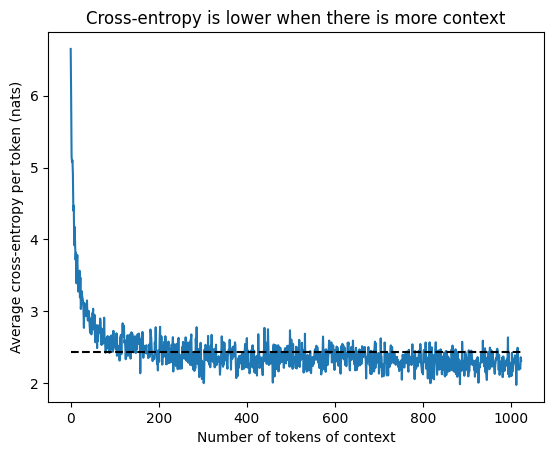

In [115]:
plt.plot(range(context_length), sample_cross_entropies.mean(axis=0))
plt.hlines(sample_cross_entropies.mean(), 0, context_length, color='black', linestyle='dashed')
plt.title('Cross-entropy is lower when there is more context')
plt.ylabel('Average cross-entropy per token (nats)')
plt.xlabel('Number of tokens of context');

print(f'''Loss at 1 token of context: {sample_cross_entropies[:,0].mean():0.2f} nats/token
Loss at 20 tokens of context: {sample_cross_entropies[:,19].mean():0.2f} nats/token
Loss at {context_length} tokens of context: {sample_cross_entropies[:,-1].mean():0.2f} nats/token

Average over all context windows: {sample_cross_entropies.mean():0.2f} nats/token''')

That's because they have less context; the first position only has one token of context $P(t_2 \vert t_1)$ (we don't estimate $P(t_1)$ here, we'll come back to this when we look at multiple texts) - it's very difficult to guess what comes after 1 token:

In [116]:
for t in tokenizer.batch_decode(input_ids[:,:1]):
    print(t.replace('\n', '↵') + '\n')

 and

↵

 

 designs



When you've got more context you have some chance of guessing:

In [117]:
for t in tokenizer.batch_decode(input_ids[:,:30]):
    print(t.replace('\n', '↵') + '\n')

 and punctuation, we made some cuts in the manuscript, I feeling that Ernest would surely have made them himself.  The book is all Ernest's

↵[[Category:Condensed matter physics| ]]↵&lt;!-- [[Category:Physics]] redundant supercat --&gt;↵

   <title>Hellbender</title>↵    <id>14465</id>↵    <revision>

 designs. Recently, several manufacturers are offering built modules ready to be integrated in audio systems.↵An early and prolific area of application is high-powered



Looking at the histogram of cross-entropies the model doesn't always make good predictions even with 30 tokens of context, but the predictions are often much more likely than with 1 token of context.

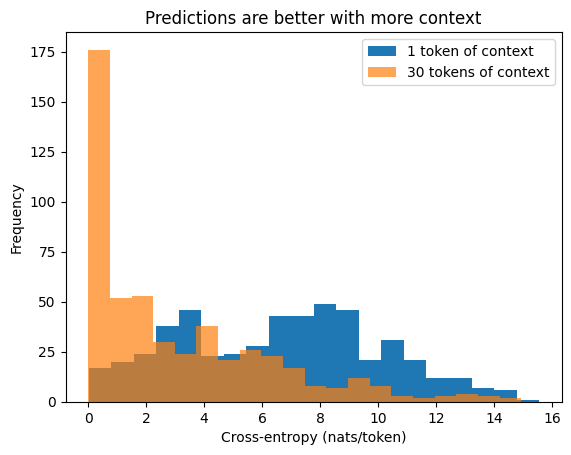

In [118]:
plt.hist(sample_cross_entropies[:,0], bins=20, label='1 token of context')
plt.hist(sample_cross_entropies[:,29], bins=20, label='30 tokens of context', alpha=0.7)
plt.legend()
plt.title('Predictions are better with more context')
plt.ylabel('Frequency')
plt.xlabel('Cross-entropy (nats/token)');

### Striding across the text

One way to really compress the text within a transformer's finite-window is to split the text into blocks and compress each block, of fixed size separately.
To maximise compression we can have the blocks overlap to increase the amount of context, only compressing new section in each block.
This increases the number of blocks but also compresses the text much more effectively.
Note that for a model like an RNN, RWKV, or Mamba we don't need to have these blocks since the hidden state can be propagated along the whole length of text.

As an example suppose we had a maximum context length of 8 tokens, and wanted to always have a context length of at least 3 tokens (that is the overlap between this window and the previous is 3 tokens).

In [119]:
max_tokens = 8
min_context = 3

The first block covers the tokens in positions (there's no additional context to look back to):

In [120]:
idx = 0
end_idx = max_tokens

idx, end_idx

(0, 8)

We get the corresponding tokens:

In [121]:
input_ids = tokens[idx:idx+max_tokens].to(model.device)

And targets (next tokens):

In [122]:
target_ids = tokens[idx+1:end_idx+1].to(model.device)

Then calculate the logits and total cross-entropy:

In [123]:
logits = model(input_ids).logits

In [124]:
F.cross_entropy(logits, target_ids, reduction='sum')

tensor(31.2013, device='cuda:0', grad_fn=<NllLossBackward0>)

For the next block we want to start compressing the section where the last window ended:

In [125]:
idx = end_idx
idx

8

But we want to look back `min_context` tokens for additional context for the next block (which we can also do at decompresion time)

In [126]:
start_idx = idx - min_context
start_idx

5

The block then ends `max_tokens` after this `start_idx`:

In [127]:
end_idx = start_idx + max_tokens
end_idx

13

Our input tokens is then the whole block from `start_idx` to `end_idx`:

In [128]:
input_ids = tokens[start_idx:end_idx].to(model.device)
input_ids

tensor([ 5907,  2625,  4023,  1378,  2503,    13, 11431, 15466],
       device='cuda:0')

But our target is only over the section we want to compress, the tokens after `idx` through to `end_idx`:

In [129]:
target_ids = tokens[idx+1:end_idx+1].to(model.device)
target_ids

tensor([ 2503,    13, 11431, 15466,    13], device='cuda:0')

We get the model's predicted logits over the whole block:

In [130]:
logits = model(input_ids).logits
logits.shape

torch.Size([8, 50257])

And calculate the total cross-entropy, but only over the target section we want to compress:

In [131]:
cross_entropy = F.cross_entropy(logits[-len(target_ids):],
                                target_ids,
                                reduction='sum')
cross_entropy

tensor(9.4940, device='cuda:0', grad_fn=<NllLossBackward0>)

We would then continue on with the next end index:

In [132]:
idx = end_idx
idx

13

We can put this all together in a function, taking particular care with the first block (where there's no context) and the last block (which may not be a full block).
It would be more efficient to run inference in batches, but I do it one at a time because the code is simpler to read:

In [133]:
def stride_cross_entropy(tokens, max_tokens=1024, min_context=256):

    if min_context >= max_tokens:
        raise ValueError()
    
    cross_entropy = 0.

    idx = 0
    while idx < len(tokens):
        start_idx = max(idx - min_context, 0)
        end_idx = min(start_idx + max_tokens, len(tokens))
        
        input_ids = tokens[start_idx:end_idx].to(model.device)
        target_ids = tokens[idx+1:end_idx+1].to(model.device)
    
        with torch.inference_mode():
            logits = model(input_ids).logits[-len(target_ids):]
            cross_entropy += F.cross_entropy(logits[-len(target_ids):],
                                             target_ids,
                                             reduction='sum').item()
    
        idx = end_idx

    return cross_entropy / len(tokens)
        
cross_entropy_windowed = stride_cross_entropy(tokens)

We can then calculate the entropy with a context of 256 tokens over a window of 1024:

In [134]:
tokens_per_byte * cross_entropy_windowed / math.log(2)

0.9813043866209555

If we increase the amount of context to 768 we get something just a little higher than the claimed 0.93 (I don't run the maximum 1023 because it will take a very long time):

In [135]:
cross_entropy_768 = stride_cross_entropy(tokens, min_context=768)
tokens_per_byte * cross_entropy_768 / math.log(2)

0.9688098539751745

# Comparing Language Model Metrics

I hope this article makes it easier to understand the links between different compression metrics, but also the subtlety in comparing metrics across models.
When comparing perplexity or average cross-entropy it's important to know the same tokenization was used across models and for cross-entropy knowing the unit (base of logarithm used).
The metrics bits-per-byte and bits-per-character are easier to compare (as long as you know the text encoding), since they are the cross-entropy in base 2, averaged over the bytes/characters respectively.
When calculating perplexity for transformer models you have to take into account the sequence length used, and for long texts the amount of context used in each window (the more context the better the metrics, but the slower the evaluation).

Older language modelling datasets have a fixed-word vocabulary and anything outside is represented with an unknown token (like `<UNK>`), and it's a little subtle how you calculate the cross-entropy of this token; it's technically infinite, but you could either skip it or explicitly assign a probability to it.
The advantage of a BPE tokenizer in GPT-2 is all possible byte strings can be encoded and decoded, and should have a non-zero probability.
However if you wanted to compare results on these datasets fairly you would need to know how they score out of vocabulary tokens.

For datasets with multiple texts you need to decide whether you micro-average or macro-average the results.
Typically in the loss function and metrics the results are micro-averaged, that is you calculate the cross-entropy loss across the whole dataset and divide by the total number of tokens.
This gives a good estimate of the compressibility of the whole dataset, but it puts more weight on longer texts with more tokens.
An alternative would be to macro-average the results; calculate the cross-entropy loss for each text separately and take the average of those losses; this is akin to averaging the compression ratios over lots of files.

You should now have the tools to understand and compare the language modelling capabilities of real models, especially ones you train.
Keep in mind that language modelling aims to minimise the cross-entropy loss on the *training corpus* and if you calculate cross-entropy loss on a corpus with a different distribution you will get a worse (higher) number; you might want to fine-tune it a little to make it more comparable.
Also for instruction-tuned (or otherwise supervised fine-tuned) models the predictions get further from true probabalistic predictions of the likelihood of text.